In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
from pytesseract import Output
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

## First Experiment

In [4]:
path = r'raw_data\helvetios_challenge_dataset_training\images'
img_names = ['20220915194538484039.png', '20220915194540522606.png', '20220915194541155437.png', '20220915194542124279.png']
imgs = [cv2.imread(path + '\\' + img_name) for img_name in img_names]

In [5]:
custom_config = r'--oem 3 --psm 6'
for img in imgs: 
    print("---------")
    print(pytesseract.image_to_string(img, config=custom_config))
    print("---------")

---------
Gamma Ray - GR [08]
Energy (Btu)
a - 2° $ 2 »
3 See gh
9 ee ee
4". Fhe ae |
: : a r] mere rT) ”
"a
2

---------
---------
Far Windoivs Carbon/ Oxygen Ratio
TimePerMass (fU(N.)) ~ ao
462.1 5218 593.5 659.2 750 ~
: eg BB —+—"§ :
: xx— 249, ° ‘ °
: é °
g | eu { —~—-35.94X ‘ .
ees ya x xy
eX | a ; |
wet! ; 3209

---------
---------
= tees - . ong Pte te
wa Average of First Echo Amplitude = * : rene
ce ee ay , : Se ee ea
| ahs . ~ an wae. _egienauctonce em) . . te Oe
‘ we RE . :
ety + 16, ge Bh wm 459 a 696 934 rae
. Dk ~~ - 5
ko er . otaw +
{a(S + tee a
Gof? ae le Boe igs OL gt ~
7 2 ef ia ae par aie “tt ee +
° > = ea E 2. . © ° ‘e- #8. +? ° ‘
= aa %. Pleo . .° tel ro eG - . -
* B® Ls. & ee oF * or yt
ena Fe tA Ls
° 2 ce - ~ 7
7& —_ ,

---------
---------
Sodium Activation]
temprature

2S 9 ° > 9
S co es a
J 2134
& & Ask | vv”
SZ 2336¢ Vu - —

X_Umestone '
= 253.91 @ on << dave e
2 2741 oF mn *
: Fore
Sw 204.4 K—§y
z sue! ©
wn
2
&

---------


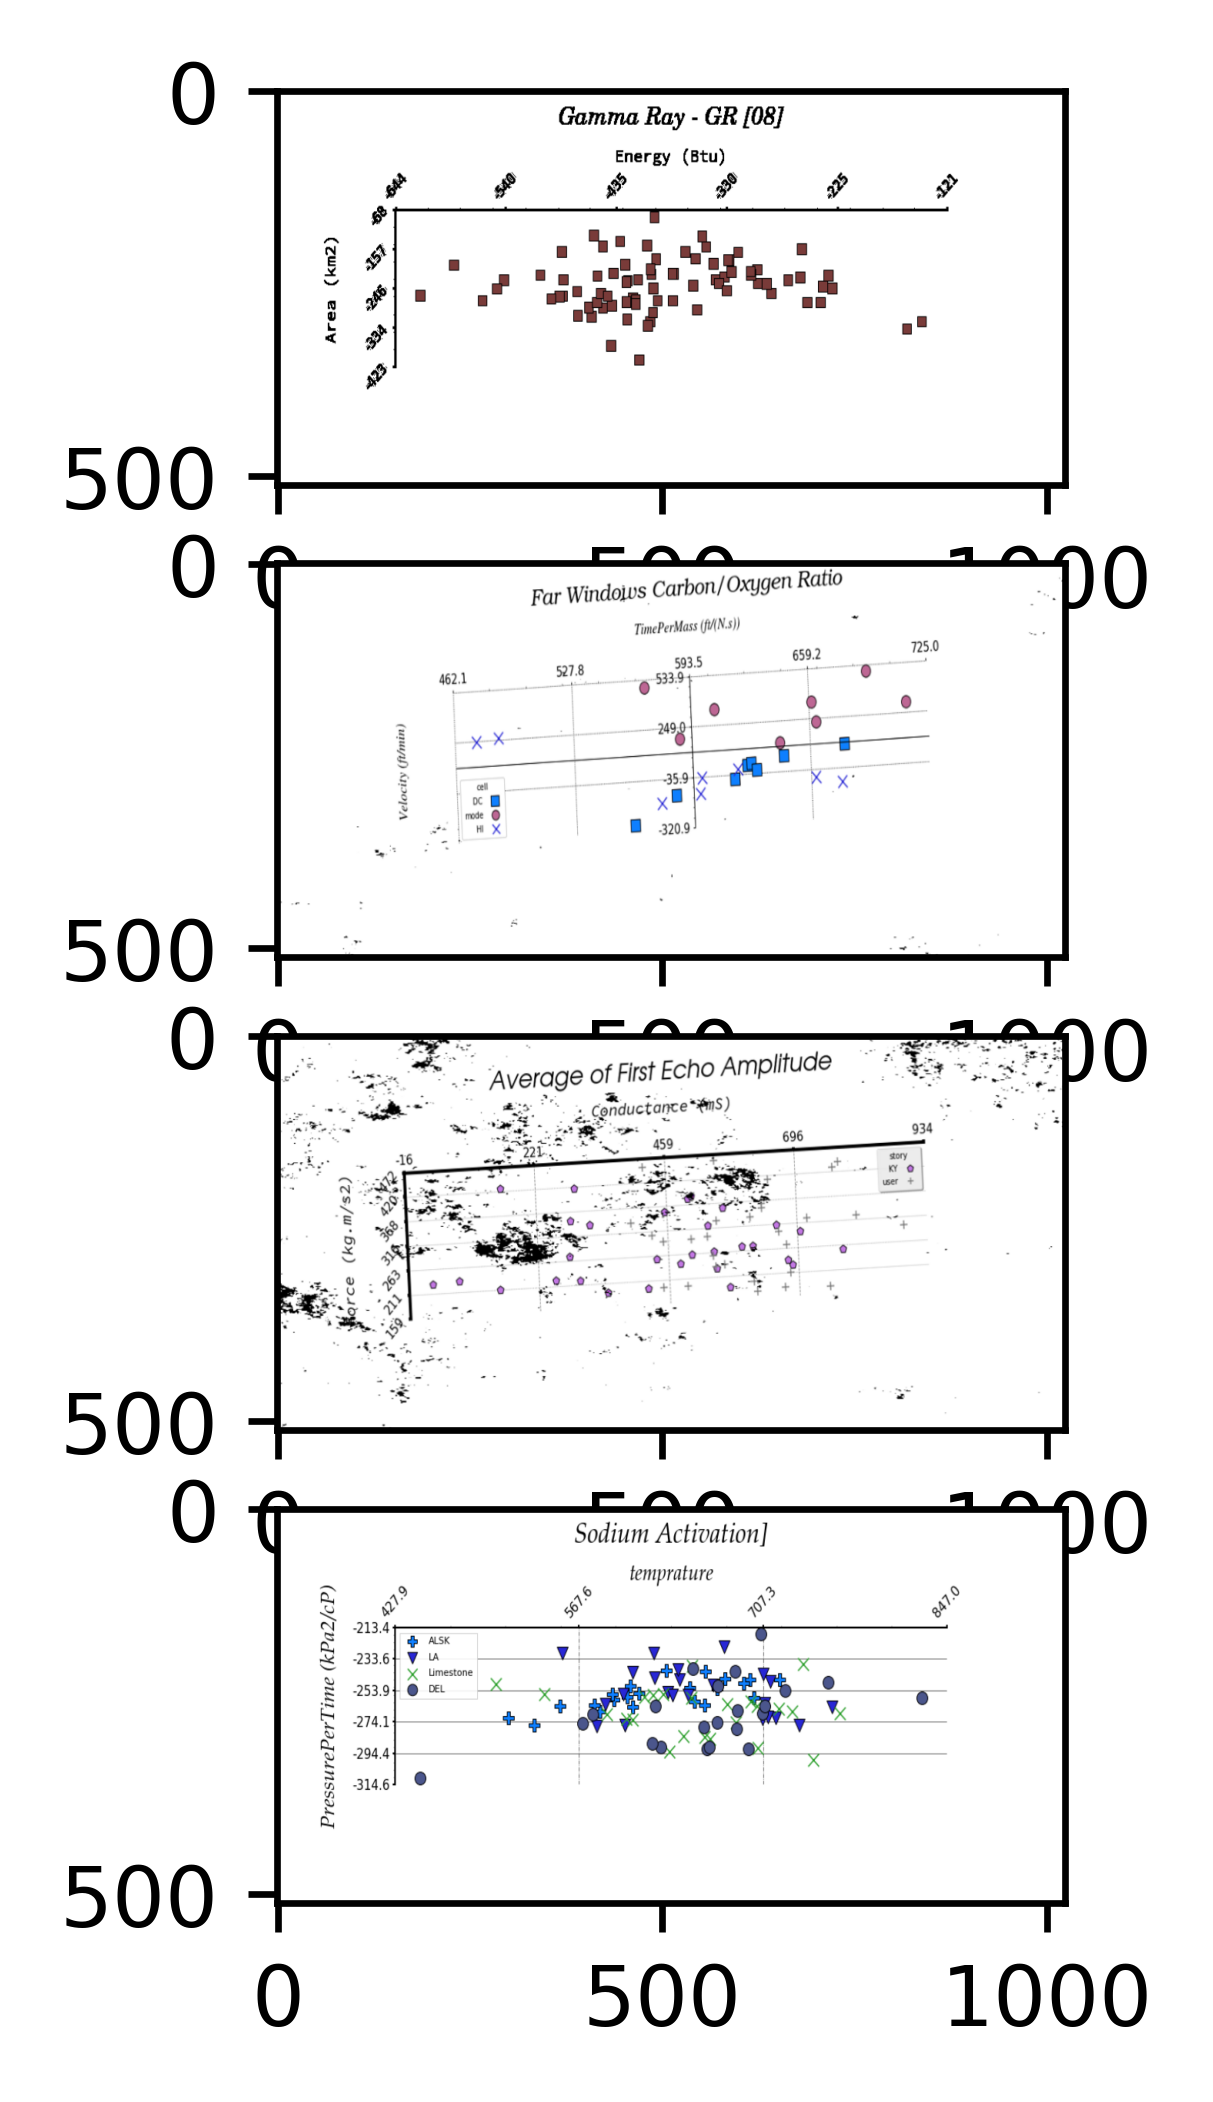

In [6]:
plt.figure(dpi=600)
for i in range(len(imgs)):
    plt.subplot(len(imgs), 1, i+1)
    plt.imshow(cv2.cvtColor(imgs[i], cv2.COLOR_BGR2RGB))

Conclusion: Results not satisfying, problem with noise, legend text is hardly found nor predicted correctly

## Preprocessing

In [7]:
# from https://nanonets.com/blog/ocr-with-tesseract/

# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)

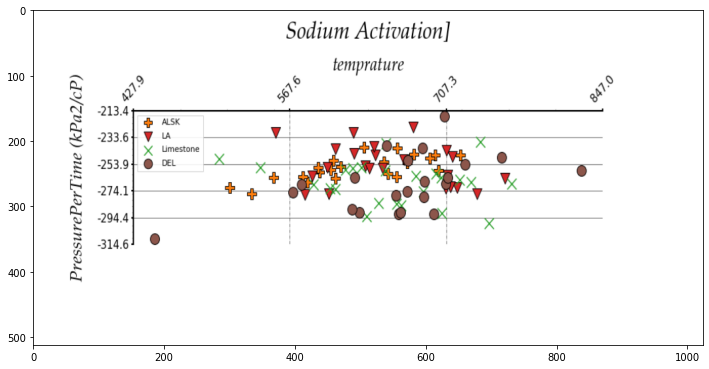

In [8]:
ax = plt.figure(figsize=(12,8)).add_subplot()
img = imgs[3]
ax.imshow(img)

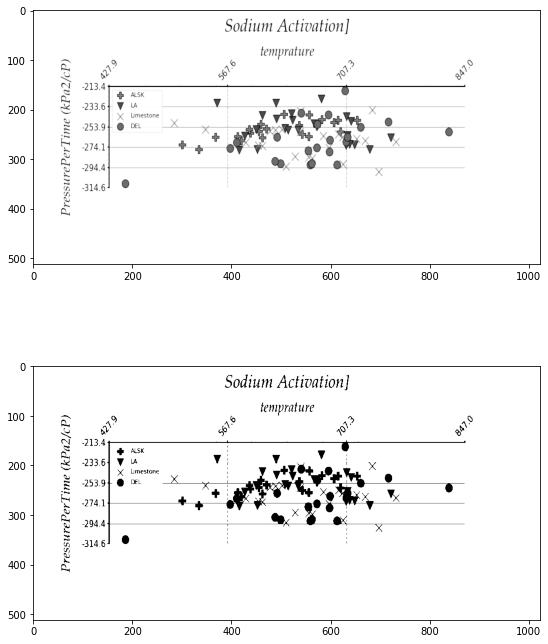

In [9]:
fig = plt.figure(figsize=(20,12))

img = get_grayscale(img)
fig.add_subplot(221)
plt.imshow(img, cmap='Greys_r')
img = thresholding(img)
fig.add_subplot(223)
plt.imshow(img, cmap='Greys_r')

In [10]:
print(pytesseract.image_to_string(img, config=custom_config))

Sodium Activation]
temprature

2 % % > S
g # @ $
3 234 Y 4
Sd ye oy Naps cee *
= 2539t @ on a a ®
2m ke mn *
© ef
we 2044 i—x
5 346! @
2
x



## Boxes Around Text

dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])


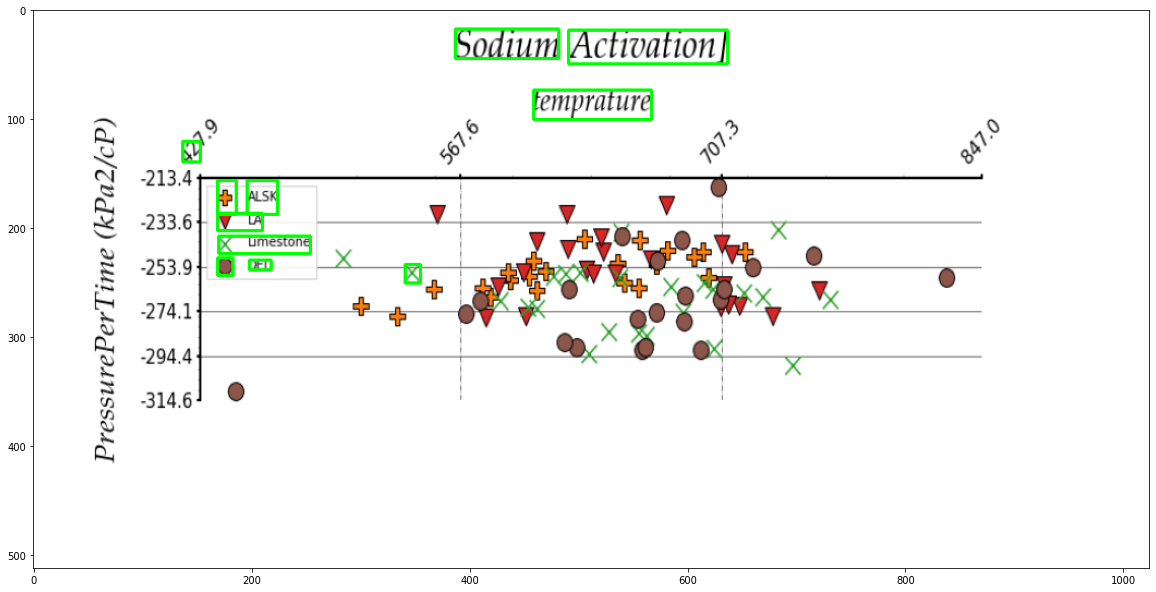

In [11]:
custom_config = r'-l eng+grc -c tessedit_char_blacklist=0123456789 --psm 11' # import to choose best psm!
img = imgs[3].copy()
d = pytesseract.image_to_data(img, output_type=Output.DICT, config=custom_config)
print(d.keys())
n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(d['conf'][i]) > 40:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

fig = plt.figure(figsize=(20,12))
plt.imshow(img, cmap='Greys_r')

In [12]:
custom_config = r'-l eng+grc -c tessedit_char_blacklist=0123456789 --psm 11' # import to choose best psm!
img = imgs[3].copy()
result = []
d = pytesseract.image_to_data(img, output_type=Output.DICT, config=custom_config)
n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(d['conf'][i]) > 15:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        (x, y, w, h) = (x-5, y-5, w+10, h+10)
        crop_img = img[y:y+h, x:x+w]
        result.append(pytesseract.image_to_string(crop_img, config=custom_config))
print(result)

['Sodium\n', 'Activation]\n', 'temprature\n', 'w\n', 'g\n', '', 'ASK\n\ni\n', 'vu\n', 'Limestone\n', '', 'DEL\n', '', '', 'We\n\nwns\n\n&\n\n%.\n']


In [53]:
post_processing1 = lambda l: [ee for e in l for ee in e.strip().split("\n")]
post_processing2 = lambda l: list(filter(("").__ne__, [e.strip().replace("\n", "") for e in l]))
post_processing = lambda l: post_processing2(post_processing1(l))

In [54]:
print(post_processing(result))

['Sodium', 'Activation]', 'temprature', 'w', 'g', 'ASK', 'i', 'vu', 'Limestone', 'DEL', 'We', 'wns', '&', '%.']


## Model Comparison Function

In [60]:
def simple_model_comparison(list_of_labels, list_of_ocr_results):
    """both inputs as list of lists"""
    scores = []
    for (label_list, result_list) in zip(list_of_labels, list_of_ocr_results):
        detected_count = 0
        for word in label_list:
            detected_count += (word in result_list)
        detected_relative = detected_count / len(label_list)
        scores.append(detected_relative)
    return sum(scores)/len(scores)


In [61]:
# made-up example
ex_ll = [["ASK", "Limestone", "DEL", "LA"], ["Test", "Check"], ["Uff", "Keine", "Idee", "Mehr"]]
ex_lr = [['Sodium', 'Activation]', 'temprature', 'w', 'g', 'ASK', 'i', 'vu', 'Limestone', 'DEL', 'We', 'wns', '&', '%.'], ["Test", "Check"], ["Nix", "Gefunden"]]
simple_model_comparison(ex_ll, ex_lr)

0.5833333333333334

In [62]:
##### test the model above here

## Tuning

How to improve the model for our data?
In order to successfully run the Tesseract 4.0 LSTM training tutorial, you need to have a working installation of Tesseract 4 and Tesseract 4 Training Tools and also have the training scripts and required trained data files in certain directories. Tesseract 4.00 takes a few days to a couple of weeks for training from scratch. Even with all these new training data, therefore here are few options for training:

- Fine-tune - Starting with an existing trained language, train on your specific additional data.
- Cut off the top layer - from the network and retrain a new top layer using the new data. If fine-tuning doesn't work, this is most likely the next best option. By retraining only top layers you are using knowledge from lower layers and combining with your new different dataset.
- (Retrain from scratch - This is a very slow approach unless you have a very representative and sufficiently large training set for your problem https://github.com/Shreeshrii/tess4training)

In [63]:
##### tune/improve model here